In [64]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
from tqdm import tqdm
import time

%matplotlib inline

In [120]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flicker/flick8r
/kaggle/input/flick8r/Flickr8k_text/ExpertAnnotations.txt
/kaggle/input/flick8r/Flickr8k_text/readme.txt
/kaggle/input/flick8r/Flickr8k_text/Flickr_8k.devImages.txt
/kaggle/input/flick8r/Flickr8k_text/Flickr8k.lemma.token.txt
/kaggle/input/flick8r/Flickr8k_text/Flickr_8k.testImages.txt
/kaggle/input/flick8r/Flickr8k_text/Flickr8k.token.txt
/kaggle/input/flick8r/Flickr8k_text/Flickr_8k.trainImages.txt
/kaggle/input/flick8r/Flickr8k_text/CrowdFlowerAnnotations.txt
/kaggle/input/flick8r/Flickr8k_Dataset/3218889785_86cb64014f.jpg.npy
/kaggle/input/flick8r/Flickr8k_Dataset/390671130_09fdccd52f.jpg.npy
/kaggle/input/flick8r/Flickr8k_Dataset/1527513023_3d8152b379.jpg.npy
/kaggle/input/flick8r/Flickr8k_Dataset/3273625566_2454f1556b.jpg.npy
/kaggle/input/flick8r/Flickr8k_Dataset/3699318394_6193f2c8e0.jpg.npy
/kaggle/input/flick8r/Flickr8k_Dataset/140377584_12bdbdf2f8.jpg.npy
/kaggle/input/flick8r/Flickr8k_Dataset/84713990_d3f3cef78b.jpg.npy
/kaggle/input/flick8r/Fl

In [121]:
BASE = '/kaggle/input/flick8r'

IMAGE_PATH = os.path.join(BASE, 'Flickr8k_Dataset')
CAPTION_PATH = os.path.join(BASE, 'Flickr8k_text')
CAPTION_FULL = os.path.join(CAPTION_PATH, 'Flickr8k.token.txt')

BASE = '/kaggle/input/flick8r': This sets the base directory path where the Flickr8k dataset is located. It seems to be assuming a directory structure commonly used in Kaggle competitions, where datasets are typically stored under /kaggle/input/.

IMAGE_PATH = os.path.join(BASE, 'Flickr8k_Dataset'): This creates a path to the directory containing the images in the Flickr8k dataset. It uses os.path.join() to ensure the path is constructed correctly across different operating systems.

CAPTION_PATH = os.path.join(BASE, 'Flickr8k_text'): This creates a path to the directory containing the caption files for the images in the Flickr8k dataset.

CAPTION_FULL = os.path.join(CAPTION_PATH, 'Flickr8k.token.txt'): This creates a path to the specific caption file named Flickr8k.token.txt within the caption directory. This file likely contains the image file names along with their corresponding captions.

In [67]:
#showing some example
with open(CAPTION_FULL) as f:
    for i in range(10):
        print(f.readline())

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .

1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .

1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .

1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .

1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting

1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .

1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .

1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .

1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .



# **Caption Mapping For Evaluation**

In [68]:
#seqence start and seqence end
SEQ_START = '<start>'
SEQ_END = '<end>'

In [69]:
os.listdir(BASE)

['Flickr8k_text', 'Flickr8k_Dataset']

The os.listdir(BASE) function call will return a list of the files and directories in the directory specified by the BASE path. It essentially gives you a way to see what files and subdirectories are contained within the BASE directory. This can be useful for exploring the contents of a directory programmatically.

In [70]:
#mapping image id to list of captions
captions_map = defaultdict(list)

with open(CAPTION_FULL) as file:
    lines = file.readlines()
    for line in lines:
        data = line.split('\t')
        image_id = data[0].split('#')[0]
        caption = SEQ_START + ' ' + data[1].strip() + ' ' + SEQ_END
        if not os.path.exists(os.path.join(IMAGE_PATH, image_id + '.npy')):
            continue
        captions_map[image_id].append(caption)

* **captions_map = defaultdict(list):** This line initializes a defaultdict with a default value of an empty list. This data structure will be used to store the mapping of image IDs to their captions.

* **with open(CAPTION_FULL) as file::** This opens the caption file (Flickr8k.token.txt) specified by the CAPTION_FULL path for reading.

* **lines = file.readlines():** This reads all lines from the file and stores them in the lines list.

* **for line in lines::** This iterates over each line in the file.

* **data = line.split('\t'):** This splits each line into two parts based on the tab character ('\t'). The first part is the image ID and the caption ID, separated by a #.

* **image_id = data[0].split('#')[0]:** This extracts the image ID from the first part of the split line by splitting it again at the # character and taking the first part.

* **caption = SEQ_START + ' ' + data[1].strip() + ' ' + SEQ_END:** This constructs the caption by adding start and end sequence tokens (SEQ_START and SEQ_END, presumably defined elsewhere) to the caption text, which is stripped of leading and trailing whitespace.

* **if not os.path.exists(os.path.join(IMAGE_PATH, image_id + '.npy')):**: This checks if the corresponding image file exists in the IMAGE_PATH directory. It assumes that image files are stored as .npy files with filenames matching the image IDs.

* **captions_map[image_id].append(caption)**: If the image file exists, it appends the caption to the list of captions associated with the image ID in the captions_map dictionary.

In [71]:
#Total number of images
len(list(captions_map.keys()))

8091

In [72]:
all_captions = []
all_image_paths = []
for image_id in captions_map:
    all_captions.extend(captions_map[image_id])
    all_image_paths.extend([os.path.join(IMAGE_PATH, image_id)] * len(captions_map[image_id]))

This code snippet is flattening the captions_map dictionary into two separate lists: all_captions and all_image_paths. Here's what it does:

all_captions = []: Initializes an empty list to store all the captions.

all_image_paths = []: Initializes an empty list to store all the image paths.

for image_id in captions_map:: Iterates over each key (image ID) in the captions_map dictionary.

all_captions.extend(captions_map[image_id]): Extends the all_captions list with all the captions associated with the current image_id.

all_image_paths.extend([os.path.join(IMAGE_PATH, image_id)] * len(captions_map[image_id])): Extends the all_image_paths list with the full path to the image corresponding to image_id, repeated for each caption associated with that image_id. The * len(captions_map[image_id]) part replicates the image path to match the number of captions for that image.

After this code snippet executes, all_captions will contain all the captions from the captions_map dictionary, and all_image_paths will contain the corresponding paths to the images. These lists can be used together to associate each caption with its corresponding image path for further processing.

In [73]:
##showing captions 
all_captions[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

In [74]:
#showing image paths
all_image_paths[:5]

['/kaggle/input/flick8r/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flick8r/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flick8r/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flick8r/Flickr8k_Dataset/1000268201_693b08cb0e.jpg',
 '/kaggle/input/flick8r/Flickr8k_Dataset/1000268201_693b08cb0e.jpg']

In [75]:
#show total number of captions
len(all_captions)

40455

In [76]:
#show total number of images
len(all_image_paths)

40455

# **Tokenize captions**

Tokenizing captions is a crucial step in natural language processing tasks, especially in machine learning models that deal with text. By tokenizing captions, we convert the textual data into a format that can be easily processed by the model. Each word in the caption is replaced with a unique integer, which allows the model to understand and manipulate the text more effectively. Tokenization also helps in standardizing the input data, such as converting all text to lowercase and removing special characters or punctuation marks. Overall, tokenizing captions is essential for preparing textual data for use in machine learning models, enabling them to learn patterns and generate meaningful output based on the input captions.

In [77]:
#Convert captions to tensor
caption_dataset = tf.data.Dataset.from_tensor_slices(all_captions)

**PreProcessing**

In [78]:
#text preprocessing
def standardize(inputs):
    inputs = tf.strings.lower(inputs)
    return tf.strings.regex_replace(inputs,
                                    r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

inputs = tf.strings.lower(inputs): This line converts all characters in the inputs string to lowercase using tf.strings.lower(). This step ensures that the text is consistent in terms of capitalization, which can be important for text processing tasks.

return tf.strings.regex_replace(inputs, r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_{|}~", ""): This line uses tf.strings.regex_replace()to remove specific special characters and punctuation marks from theinputsstring. The regular expressionr"!"#$%&
*+.,-/:;=?@
^_{|}~" matches these characters and replaces them with an empty string, effectively removing them from the text.

This standardize function is designed to preprocess text data by converting it to lowercase and removing certain special characters, making the text cleaner and more standardized for further processing in natural language processing tasks.

**Text Vectorization**

In [79]:
# Parameters for tokenizer
MAX_LENGTH = 50
VOCAB_SIZE = 5000

# Tokenizer
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=standardize,
    output_sequence_length=MAX_LENGTH)

# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

**MAX_LENGTH = 50 and VOCAB_SIZE = 5000:** These parameters define the maximum length of sequences (MAX_LENGTH) and the maximum vocabulary size (VOCAB_SIZE) for the tokenizer. Sequences longer than MAX_LENGTH will be truncated, and the tokenizer will only consider the top VOCAB_SIZE most common words in the dataset.

**tokenizer = tf.keras.layers.TextVectorization(...):**

max_tokens=VOCAB_SIZE: Specifies the maximum vocabulary size for the tokenizer.
standardize=standardize: Specifies the standardization function to use for preprocessing text. In this case, it's the standardize function defined earlier, which converts text to lowercase and removes certain special characters.

**output_sequence_length=MAX_LENGTH:** Specifies the maximum length of the output sequences. Sequences
longer than this will be truncated, and shorter sequences will be padded.

**tokenizer.adapt(caption_dataset):** This line adapts the tokenizer to the caption dataset, allowing it to learn the vocabulary from the caption data. During adaptation, the tokenizer processes the text and builds its vocabulary based on the specified parameters (VOCAB_SIZE and MAX_LENGTH). This step is important before using the tokenizer to encode text data into sequences of integers.


In [80]:
# Tokenize and vectorize captions
caption_vectors = caption_dataset.map(lambda x: tokenizer(x))

In [81]:
for cap in caption_vectors.take(1):
    print(cap)

tf.Tensor(
[  3   2  45   6   2  93 173   9 122  56   2 400  14 397   6  31   1 698
   5   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int64)


 prints the first tokenized caption from the caption_vectors dataset. The dataset contains tokenized versions of captions, likely processed using the configured tokenizer. The take(1) method retrieves only one element from the dataset, and the print function displays it. The output is a tensor representing a single caption, with each integer corresponding to a token in the caption based on the tokenizer's vocabulary. The length of the tensor is determined by MAX_LENGTH (set to 50), ensuring a consistent length for all captions. This provides a preview of how captions are tokenized and prepared for use in machine learning models.


In [82]:
word_to_index = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True)

In [83]:
# word2index and index2word (in another version)
def word2index(word):
    return tf.squeeze(word_to_index(tf.constant([word])))

def index2word(index):
    return tf.squeeze(index_to_word(tf.constant([index])))

# **Feature Extraction**

In [84]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (260, 260))  # EfficientNetB2 expects this input shape
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img, image_path

In [85]:
image_model = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet')

new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [86]:
# Get unique images
unique_image_paths = sorted(set(all_image_paths))

**Splliting the dataset into training and validation**

In [87]:
image_to_caption_vectors = defaultdict(list)
for image_path, caption in zip(all_image_paths, caption_vectors):
    image_to_caption_vectors[image_path].append(caption)

In [88]:
# Create training and validation sets using an 80-20 split randomly.
# image_keys = list(image_to_caption_vectors.keys())
random.shuffle(unique_image_paths)
slice_index = int(len(unique_image_paths) * 0.8)
train_paths, val_paths = unique_image_paths[:slice_index], unique_image_paths[slice_index:]

In [89]:
image_train_paths =[]
caption_train = []
for path in train_paths:
    caption_len = len(image_to_caption_vectors[path])
    image_train_paths.extend([path] * caption_len)
    caption_train.extend(image_to_caption_vectors[path])

image_val_paths = []
caption_val = []
for path in val_paths:
    caption_len = len(image_to_caption_vectors[path])
    image_val_paths.extend([path] * caption_len)
    caption_val.extend(image_to_caption_vectors[path])

len(image_train_paths), len(caption_train), len(image_val_paths), len(caption_val)

(32360, 32360, 8095, 8095)

In [90]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [91]:
# Load the numpy files (pre-extracted features)
def map_func(image_path, caption):
    img_tensor = np.load(image_path.decode('utf-8') + '.npy')
    return img_tensor, caption

In [92]:
dataset = tf.data.Dataset.from_tensor_slices((image_train_paths, caption_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
                            map_func, [item1, item2], [tf.float32, tf.int64]
                      )
                      , num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# **OUR MODEL**

### Mask creator

In [93]:
def create_look_ahead_mask(sequence_length):
    mask = tf.linalg.band_part(tf.ones((1, sequence_length, sequence_length)), -1, 0)
    return mask 

def create_padding_mask(decoder_token_ids):
    seq = 1 - tf.cast(tf.math.equal(decoder_token_ids, 0), tf.float32)
  
    return seq[:, tf.newaxis, :] 

In [94]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [95]:
def positional_encoding_1d(position, D):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],  # column vector
                            np.arange(D)[np.newaxis, :],  # row vector
                            D)

    # Apply the sine function to even indices
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Apply the cosine function to odd indices
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [96]:
def positional_encoding_2d(row, col, D):
    assert D % 2 == 0
    # first D/2 encode row embedding and second D/2 encode column embedding
    row_pos = np.repeat(np.arange(row), col)[:, np.newaxis]
    col_pos = np.repeat(np.expand_dims(np.arange(col), 0), row, axis=0).reshape(-1, 1)

    angle_rads_row = get_angles(row_pos,
                                np.arange(D // 2)[np.newaxis, :],
                                D // 2)
    angle_rads_col = get_angles(col_pos,
                                np.arange(D // 2)[np.newaxis, :],
                                D // 2)
    
    # apply sin and cos to odd and even indices resp.
    angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
    angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
    angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
    angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])

    pos_encoding = np.concatenate([angle_rads_row, angle_rads_col], axis=1)[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [97]:
def point_wise_feed_forward_network(
    emb_dim,  # Input/output dimensionality (or Embedding dim)
    fc_dim  # Inner-layer dimensionality (or FC dim)
):

    return tf.keras.Sequential([
        # Shape `(batch_size, seq_len, fc_dim)`.
        tf.keras.layers.Dense(fc_dim, activation='relu'),
        # Shape `(batch_size, seq_len, emb_dim)`.
        tf.keras.layers.Dense(emb_dim)
    ])


### Encoder

In [98]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, emb_dim, num_heads, fc_dim,
                 dropout_rate=0.1, layernorm_eps=1e-6):
        super(EncoderBlock, self).__init__()

        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                      key_dim=emb_dim,
                                                      dropout=dropout_rate)

        self.ffn = point_wise_feed_forward_network(emb_dim=emb_dim,
                                                   fc_dim=fc_dim)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask):
        """
            `mask` is padding mask
        """
        attn_output = self.mha(query=x, key=x, value=x,
                               training=training, attention_mask=mask)

        # (batch_size, input_seq_len, fully_connected_dim)
        out1 = self.layernorm1(attn_output + x, training=training)

        # (batch_size, input_seq_len, fully_connected_dim)
        ffn_output = self.ffn(out1, training=training)

        ffn_output = self.dropout1(ffn_output, training=training)

        # (batch_size, input_seq_len, fully_connected_dim)
        encoder_layer_out = self.layernorm2(ffn_output + out1, training=training)

        return encoder_layer_out


In [99]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 num_layers,
                 emb_dim,  # Input/output dimensionality (or Embedding dim).
                 num_heads,
                 fc_dim,  # Inner-layer dimensionality (or FC dim).
                 row_size, col_size,    # Shape of grid features
                 dropout_rate=0.1,
                 layernorm_eps=1e-6):
        super().__init__()

        self.emb_dim = emb_dim
        self.num_layers = num_layers

        # Embeddings (it's just a Dense layer)
        self.embedding = tf.keras.layers.Dense(emb_dim, activation='relu')
        # Positional encoding 2D
        self.pos_encoding = positional_encoding_2d(row_size, col_size, emb_dim)

        # Encoder layers.
        self.enc_layers = [EncoderBlock(emb_dim=emb_dim,
                                        num_heads=num_heads,
                                        fc_dim=fc_dim,
                                        dropout_rate=dropout_rate,
                                        layernorm_eps=layernorm_eps)
            for _ in range(num_layers)]

        # Dropout.
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]

        # Sum up embeddings and positional encoding.
        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len, :]

        # Add dropout.
        x = self.dropout(x, training=training)

        # N encoder blocks.
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # Shape `(batch_size, input_seq_len, emb_dim)`.


### Decoder

In [100]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 emb_dim,  # Input/output dimensionality (or Embedding dim).
                 num_heads,
                 fc_dim,  # Inner-layer dimensionality (or FC dim).
                 dropout_rate=0.1,
                 layernorm_eps=1e-6):
        super().__init__()

        # Masked multi-head self-attention.
        self.mha_masked = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            # Size of each attention head for query Q and key K.
            key_dim=emb_dim,
            dropout=dropout_rate
        )
        # Multi-head cross-attention.
        self.mha_cross = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads,
            # Size of each attention head for query Q and key K.
            key_dim=emb_dim,
            dropout=dropout_rate
        )

        # Point-wise feed-forward network.
        self.ffn = point_wise_feed_forward_network(emb_dim, fc_dim)

        # Layer normalization.
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=layernorm_eps)

        # Dropout for the point-wise feed-forward network.
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        # The encoder output shape is `(batch_size, input_seq_len, emb_dim)`.

        attn_masked, attn_weights_masked = self.mha_masked(
            query=x,
            value=x,
            key=x,
            # A boolean mask that prevents attention to certain positions.
            attention_mask=look_ahead_mask,
            # Shape `(batch_size, target_seq_len, emb_dim)`.
            return_attention_scores=True,
            training=training
        )

        out1 = self.layernorm1(attn_masked + x)

        attn_cross, attn_weights_cross = self.mha_cross(
            query=out1,
            value=enc_output,
            key=enc_output,
            # A boolean mask that prevents attention to certain positions.
            attention_mask=padding_mask,
            # Shape `(batch_size, target_seq_len, emb_dim)`.
            return_attention_scores=True,
            training=training
        )

        out2 = self.layernorm2(attn_cross + out1)

        # Shape `(batch_size, target_seq_len, emb_dim)`.
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout1(ffn_output, training=training)
        
        # Shape `(batch_size, target_seq_len, emb_dim)`.
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_masked, attn_weights_cross

In [101]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 num_layers,
                 emb_dim,  # Input/output dimensionality.
                 num_heads,
                 fc_dim,  # Inner-layer dimensionality.
                 target_vocab_size,
                 dropout_rate=0.1,
                 layernorm_eps=1e-6):
        super(Decoder, self).__init__()

        self.emb_dim = emb_dim
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(
            target_vocab_size,
            emb_dim,
            mask_zero=True
        )
        self.pos_encoding = positional_encoding_1d(MAX_LENGTH, emb_dim)

        self.dec_layers = [
            DecoderBlock(
                emb_dim=emb_dim,
                num_heads=num_heads,
                fc_dim=fc_dim,
                dropout_rate=dropout_rate,
                layernorm_eps=layernorm_eps)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # Sum up embeddings and positional encoding.
        # Shape: `(batch_size, target_seq_len, emb_dim)`.
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.emb_dim, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # The shape of x is `(batch_size, target_seq_len, emb_dim)`.
        return x, attention_weights


# **Transformer model**

In [102]:
class Transformer(tf.keras.Model):
    def __init__(self,
                 *,
                 num_layers,  # Number of encoder and decoder layers.
                 emb_dim,  # Input/output dimensionality.
                 num_heads,
                 fc_dim,  # Inner-layer dimensionality.
                 row_size, col_size,
                 target_vocab_size,  # Target (English) vocabulary size.
                 dropout_rate=0.1,
                 layernorm_eps=1e-6):
        super().__init__()
        # The encoder.
        self.encoder = Encoder(
            num_layers=num_layers,
            emb_dim=emb_dim,
            num_heads=num_heads,
            fc_dim=fc_dim,
            row_size=row_size,
            col_size=col_size,
            dropout_rate=dropout_rate,
            layernorm_eps=layernorm_eps
        )

        # The decoder.
        self.decoder = Decoder(
            num_layers=num_layers,
            emb_dim=emb_dim,
            num_heads=num_heads,
            fc_dim=fc_dim,
            target_vocab_size=target_vocab_size,
            dropout_rate=dropout_rate,
            layernorm_eps=layernorm_eps
        )

        # The final linear layer.
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, input, target, training, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
        # The encoder output.
        # `(batch_size, inp_seq_len, emb_dim)`
        enc_output = self.encoder(input, training, enc_padding_mask)

        # The decoder output shape == (batch_size, tar_seq_len, emb_dim)
        dec_output, attention_weights = self.decoder(target, enc_output, training, look_ahead_mask, dec_padding_mask)

        # The final linear layer output.
        # Shape `(batch_size, tar_seq_len, target_vocab_size)`.
        final_output = self.final_layer(dec_output)

        # Return the final output and the attention weights.
        return final_output, attention_weights

#### 2.6. Initialize model

In [103]:
num_layer = 4
emb_dim = 512
fc_dim = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = VOCAB_SIZE
dropout_rate = 0.1

In [104]:
transformer = Transformer(num_layers=num_layer,
                          emb_dim=emb_dim,
                          num_heads=num_heads,
                          fc_dim=fc_dim,
                          row_size=row_size,
                          col_size=col_size,
                          target_vocab_size=VOCAB_SIZE,
                          dropout_rate=dropout_rate)

In [105]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [106]:
learning_rate = CustomSchedule(emb_dim)

In [107]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

### Loss function

In [108]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [109]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### Checkpoints

In [110]:
checkpoint_path = './checkpoints/train'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# If a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [111]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
loss_plot = []

In [112]:
@tf.function()
def train_step(input_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
    dec_padding_mask = None

    with tf.GradientTape() as tape:
        predictions, _ = transformer(input_tensor, tar_inp, True, None, look_ahead_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)

In [113]:
N_EPOCHS = 5

for epoch in range(N_EPOCHS):
    start = time.time()

    train_loss.reset_states()

    for (batch, (img_tensor, tar)) in enumerate(dataset):
        train_step(img_tensor, tar)

        if batch % 50 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, train_loss.result()))

    print('Epoch {} Loss {:.4f}'.format(epoch + 1, train_loss.result()))

    loss_plot.append(train_loss.result())

    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

    print('------------------------------------')

Epoch 1 Batch 0 Loss 8.5287
Epoch 1 Batch 50 Loss 7.7821
Epoch 1 Batch 100 Loss 7.1777
Epoch 1 Batch 150 Loss 6.7295
Epoch 1 Batch 200 Loss 6.3608
Epoch 1 Batch 250 Loss 6.0372
Epoch 1 Batch 300 Loss 5.7584
Epoch 1 Batch 350 Loss 5.5233
Epoch 1 Batch 400 Loss 5.3261
Epoch 1 Batch 450 Loss 5.1538
Epoch 1 Batch 500 Loss 5.0003
Epoch 1 Loss 4.9855
Time taken for 1 epoch: 298.46089601516724 secs

------------------------------------
Epoch 2 Batch 0 Loss 3.5774
Epoch 2 Batch 50 Loss 3.4698
Epoch 2 Batch 100 Loss 3.4174
Epoch 2 Batch 150 Loss 3.3719
Epoch 2 Batch 200 Loss 3.3509
Epoch 2 Batch 250 Loss 3.3220
Epoch 2 Batch 300 Loss 3.2907
Epoch 2 Batch 350 Loss 3.2611
Epoch 2 Batch 400 Loss 3.2392
Epoch 2 Batch 450 Loss 3.2143
Epoch 2 Batch 500 Loss 3.1863
Epoch 2 Loss 3.1836
Time taken for 1 epoch: 286.5413885116577 secs

------------------------------------
Epoch 3 Batch 0 Loss 3.3755
Epoch 3 Batch 50 Loss 2.8946
Epoch 3 Batch 100 Loss 2.8640
Epoch 3 Batch 150 Loss 2.8457
Epoch 3 Batch 200 

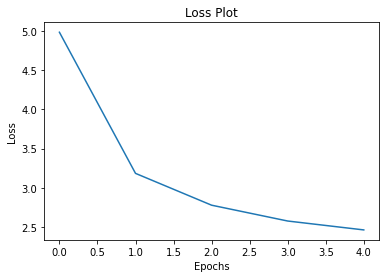

In [114]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Generate captions

In [115]:
def evaluate(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(
        img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

#     start_token = word_to_index(SEQ_START)
#     end_token = word_to_index(SEQ_END)

    decoder_input = tf.expand_dims([word2index(SEQ_START)], 0)
    result = []

    for i in range(MAX_LENGTH):
        # create look ahead mask and padding mask
        look_ahead_mask = create_look_ahead_mask(tf.shape(decoder_input)[1])
        dec_padding_mask = None     # BUG: can't use padding mask for some unknown reasons.

        predictions, attention_weights = transformer(input=img_tensor_val,
                                                     target=decoder_input,
                                                     training=False,
                                                     look_ahead_mask=look_ahead_mask,
                                                     dec_padding_mask=dec_padding_mask)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.argmax(predictions, axis=-1)

        # return the result if the predicted_id is equal to the end token
        if predicted_id[0][0].numpy() == word2index(SEQ_END):
            return result[:-1], attention_weights
        
        predicted_word = tf.compat.as_text(index2word(predicted_id[0][0].numpy()).numpy())
        result.append(predicted_word)
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)

    return result, attention_weights


In [116]:
def generate(image_path):
    if 'https://' in image_path:
        image_extension = image_path[-4:]
        image_path = tf.keras.utils.get_file('image' + image_extension, origin=image_path)

    result, _ = evaluate(image_path)
    print('Prediction Caption:', ' '.join(result))
    # opening the image
    plt.imshow(plt.imread(image_path))
    plt.show()


Prediction Caption: a brown dog is running on grass


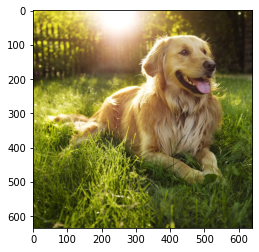

In [125]:
generate('https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/golden-retriever-royalty-free-image-506756303-1560962726.jpg?crop=0.672xw:1.00xh;0.166xw,0&resize=640:*')